In [25]:
import numpy as np
from PIL import Image
import os
import sys
import cv2
from Otsu import Otsu
from CurveDetect import CurveDetect
from tools import delete_noise, show_prediction
import sys
sys.path.append("../main/")
from validation import validate
from Devide import Devide
from skimage import morphology
from fill import fill
import seaborn
import matplotlib.pyplot as plt
from resize import to_square, from_square

In [50]:
def prob2mask(prob_map, original_image, thresh1=0.5, thresh2=0.6):
    sure_bg = (prob_map > thresh1).astype(np.uint8) * 255
    sure_fg = (prob_map > thresh2).astype(np.uint8) * 255
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown==255] = 0
    #img = np.asarray(original_image.resize((640, 640)))
    img = original_image
    img = img[:, :, :3]
    markers2 = cv2.watershed(img, markers)
    maskz = Image.fromarray((markers2 > 1).astype(np.uint8) * 255)
    return maskz

In [44]:
i = 0

1
04_6.png
[[[224 226 233]
  [226 227 232]
  [228 229 232]
  ...
  [224 226 231]
  [225 226 231]
  [225 226 231]]

 [[224 226 232]
  [226 227 232]
  [227 229 232]
  ...
  [224 226 231]
  [225 226 231]
  [225 226 231]]

 [[223 226 231]
  [225 228 231]
  [227 229 231]
  ...
  [224 226 230]
  [225 226 230]
  [225 226 230]]

 ...

 [[226 226 231]
  [228 229 231]
  [229 230 232]
  ...
  [200 128 168]
  [154 102 157]
  [121  89 151]]

 [[221 219 225]
  [224 224 228]
  [227 227 231]
  ...
  [195 126 170]
  [147 102 159]
  [113  92 153]]

 [[217 212 221]
  [220 219 226]
  [224 224 230]
  ...
  [197 124 172]
  [141  98 154]
  [102  88 144]]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
score:  0.059595419906711876
0.5 : 0.21008403361344538
0.55 : 0.152
0.6 : 0.11627906976744186
0.65 : 0.07462686567164178
0.7 : 0.03597122302158273
0.75 : 0.006993006993006993
0.8 : 0.0
0.85 : 0.0
0.9 : 0.0
0.95 : 0.0
score:  0.037538500510

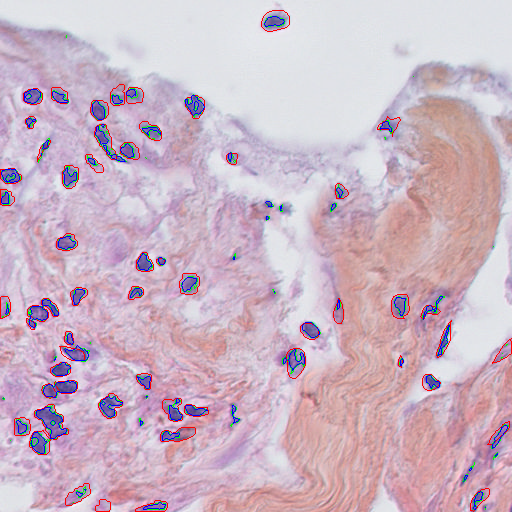

In [49]:
# validation画像の分析
VALIDATION_FILE_ROOT = "/data/unagi0/kanayama/dataset/nuclei_images/answer_val0/"
TRAIN_FILE_ROOT = "/data/unagi0/kanayama/dataset/nuclei_images/stage1_train_default/"

print(i)
filenames = os.listdir(VALIDATION_FILE_ROOT)
filename = filenames[i * 2]
print(filename)
i += 1

original_image =  Image.open(TRAIN_FILE_ROOT + '/images/' + filename)
original_image_array = np.asarray(original_image)[:, :, :3].copy()  # なぜかcopyを入れないと動かない・・・

predicted_mask = Image.open(VALIDATION_FILE_ROOT + filename)
predicted_mask_array = np.asarray(predicted_mask)

gt_mask = Image.open(TRAIN_FILE_ROOT + 'masks/' + filename)
gt_mask_array = np.asarray(gt_mask)

probs = np.load(VALIDATION_FILE_ROOT + filename.split(".png")[0] + ".npy")
original_height = original_image.size[1]
original_width = original_image.size[0]
probs_resized = from_square(probs, (original_height, original_width))

predicted_mask2 = prob2mask(probs_resized, original_image_array)
predicted_mask_array2 = np.asarray(predicted_mask2)


val, vs, _ = validate(predicted_mask_array, gt_mask_array)
threshold = np.linspace(0.5, 0.95, 10)
threshold = np.around(threshold, decimals=2)
print("score: ", val)
for v, thresh in zip(vs, threshold):
    print(thresh, ":", v)

val, vs, _ = validate(predicted_mask_array2, gt_mask_array)
threshold = np.linspace(0.5, 0.95, 10)
threshold = np.around(threshold, decimals=2)
print("score: ", val)
for v, thresh in zip(vs, threshold):
    print(thresh, ":", v)

dst = show_prediction(original_image_array, predicted_mask_array, gt_mask_array, predicted_mask_array2)
dst